# __Employee Performance Analysis__
## __INX Future Inc.__
### __Train Model__

In [1]:
# general purpose libraries
import os
from dotenv import load_dotenv

# data loading and wrangling libraries for EDA
import pandas as pd
import numpy as np

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# data splitting
from sklearn.model_selection import train_test_split

# ml models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Cross validation
from sklearn.model_selection import KFold, cross_val_score

# ML model evaluation
from sklearn.metrics import accuracy_score, classification_report

# warnings
import warnings
warnings.filterwarnings('ignore')

# load the dot env file that contains the path to data file for data privacy
dotenv_path = os.getcwd()+'\\local.env'
load_dotenv(dotenv_path=dotenv_path)

True

## Import data

In [2]:
main_df = pd.read_excel(os.getenv('data'))
main_df.head(3)

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,4,55,3,2,4,1,No,12,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,4,42,3,2,1,2,No,12,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,4,48,2,3,1,5,Yes,21,3,20,2,3,18,13,1,12,No,4


## Preprocessing the data for ML models

In [5]:
# lets prepare our dataset

ml_df = main_df.drop('EmpNumber', axis=1)
ml_df.head(2)

cat_df = ml_df.select_dtypes(['object','bool'])
num_df = ml_df.select_dtypes(['int64', 'float64'])

# OneHotEncoding of Categorical features
cat_df = pd.get_dummies(cat_df)

# concatonate the categorical and numberical datasets to make one prepared dataset for RandomForest model
ml_df = pd.concat([cat_df, num_df], axis=1)

# Splitting the dataset into X=features and y=target 
X = ml_df.iloc[:, :-1]
y = ml_df.PerformanceRating

# now lets perform the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.75, random_state=19)

## Balancing the dataset using imblearn

In [6]:
oversampling = SMOTE()
undersampling = RandomUnderSampler()

steps = (('o', oversampling), ('u', undersampling))
pipeline = Pipeline(steps=steps)

X_bal, y_bal = pipeline.fit_resample(X_train, y_train)

## Model selection using K-Fold Cross validation

K-Fold cross validation processing the data models in such a way that the model does not fall into the traps of overfitting as it creates K validation splits and performs model training and accuracy evaluation on K splits

In [11]:
# lets create a model dictionary that will be used by cross validation to perform K-Fold on each of the models
models = {
    'logr': LogisticRegression(),
    'knn': KNeighborsClassifier(n_neighbors=2),
    'Kmeans': KMeans(n_clusters=3),
    'naive_bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(128, 96, 32, 3), activation='relu'),
    'RandomF': RandomForestClassifier(n_estimators=800),
    'GrdBoostClassifier': GradientBoostingClassifier(n_estimators=800),
    'XGBoost': XGBClassifier(n_estimators=900, objective='multi:softprob', eval_metric='merror')
}

model_report = {}
for key, value in models.items():
    
    # lets first create k folds of our dataset
    kfold = KFold(n_splits=10, random_state=15, shuffle=True)
    
    # now lets train and varify each model's cross validations score
    cv_report = cross_val_score(value, X_train, y=y_train, cv=kfold, scoring='accuracy')
    model_report.update(**{
        key: (cv_report, cv_report.mean(), cv_report.std())
    })

## Lets plot the results to find out the best performing model so that we can further perform Hyperparameter tuning for that model and train it

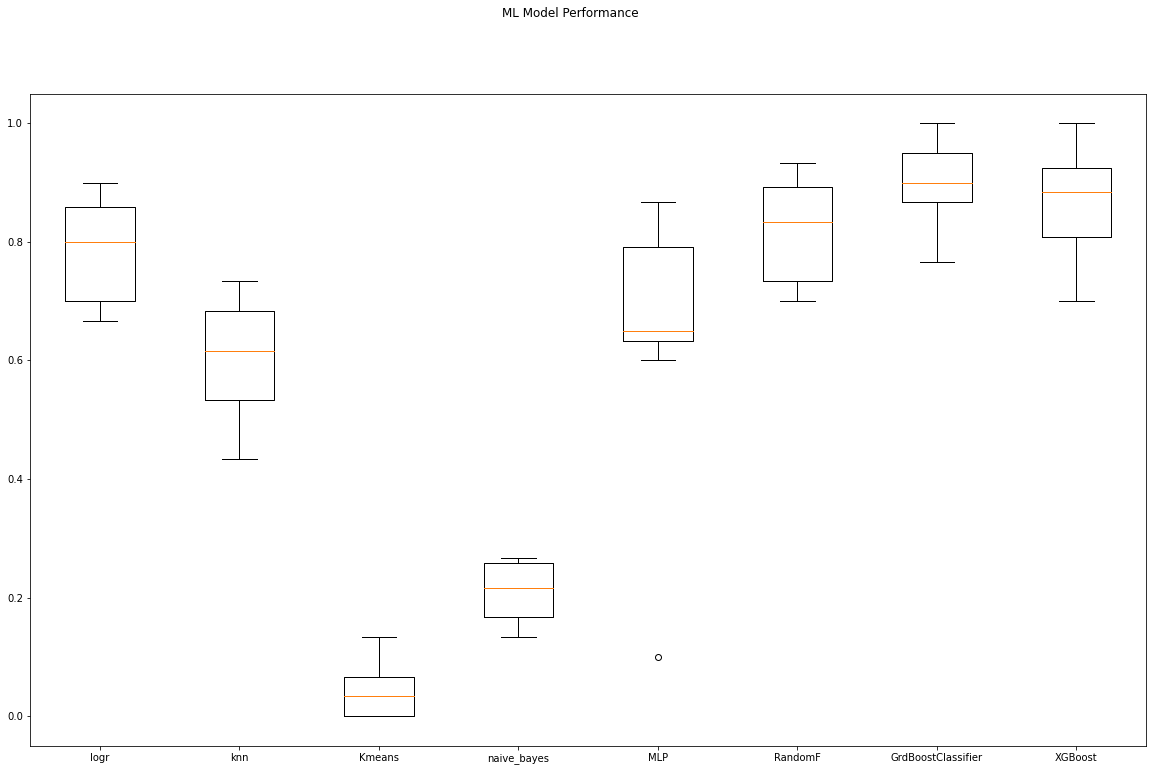

In [12]:
fig = plt.figure(figsize=(20,12))

fig.suptitle('ML Model Performance')
ax = fig.add_subplot(1,1,1)
plt.boxplot([value[0] for value in model_report.values()])
ax.set_xticklabels([key for key in model_report.keys()])
plt.show()

## Selected ML models

The winner here are clearly __GradientBoostClassifier__ and __XGBClassifier__ who have won by a great margin and hence our selected models for training are:

1. __GradientBoostClassifier__
2. __XGBClassifier__

- Now lets perform Hyperparameter tuning for these two models to figure out the best model and best parameters for the model

## Hyperparameter tuning on GradientBoostClassifier

we shall use the sklearn's GridSearchCV to perform hyperparameter tuning and we shall use the parameter grid to select the best combination of parameters to provide us with the best possible results

In [20]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [23]:
# lets first create the hyperparameter grid

gb_params ={
    'n_estimators': [700, 800, 900],
    'learning_rate' : [0.1,0.2],
    'max_depth': [9, 10, 11],
    'min_samples_leaf': [2,3],
    'subsample': [0,1],
    'max_features' : ['auto','sqrt','log2'],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae']
}
model = GradientBoostingClassifier()

random_search = RandomizedSearchCV(
    model, 
    gb_params, 
    cv=4, 
    n_jobs=1, 
    verbose=0, 
    return_train_score=True
)

random_search.fit(X_bal, y_bal)

RandomizedSearchCV(cv=4, estimator=GradientBoostingClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.1, 0.2],
                                        'max_depth': [9, 10, 11],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3],
                                        'n_estimators': [700, 800, 900],
                                        'subsample': [0, 1]},
                   return_train_score=True)

In [24]:
print(random_search.best_params_)
print(random_search.best_score_)

{'subsample': 1, 'n_estimators': 700, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 11, 'learning_rate': 0.1, 'criterion': 'mae'}
0.9633772257967979


## Hyperparameter tuning on XGBClassifier

In [25]:
# lets first create the hyperparameter grid

xgb_params ={
    'n_estimators': [400 ,500, 600, 700, 800, 900],
    'booster': ['gbtree','dart'],
    'use_label_encoder': True, 
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [7, 8, 9, 10, 11, 12, 14],
    'tree_method': ['auto','exact','approx','hist','gpu_hist'],
    'objective' : 'multi:softprob',
    'n_jobs': -1,
    'eval_metric': 'merror'
}

model = XGBClassifier()

random_search = RandomizedSearchCV(
    model, 
    gb_params, 
    cv=4, 
    n_jobs=1, 
    verbose=0, 
    return_train_score=True
)

random_search.fit(X_bal, y_bal)

print(random_search.best_params_)
print(random_search.best_score_)

[16:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "max_features", "min_samples_leaf" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "criterion", "max_features", "min_samples_leaf" } might not be used.

  This may not be accurate due to some parameters are only used in language bi

## Conclusion we shall use the parameters provided by RandomizedSearchCV for training our models

## Further hyperparameter tuning
- A futher tuning of these hyperparameters can be gained using GridSearchCV as that will give out thee best available parametric values for our models but it has not been used here due to the compute time and resource restrictions as it takes up more time and more resources to perform hyperparameter tuning as it tries out all possible combinations of parameters provided in the parameter grid.